In [1]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Other common imports
import numpy as np
import os
from pathlib import Path

from matplotlib import pyplot as plt

/home/sfefilatyev/projects/tensorflow_exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sfefilatyev/projects/tensorflow_exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sfefilatyev/projects/tensorflow_exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [2]:
#Tackling the SketchRNN Dataset

DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

In [3]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [4]:
train_files

['/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [5]:
eval_files

['/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [6]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [7]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [8]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [9]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [10]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [11]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [12]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.227451   -0.08955222  0.        ]
  [-0.10980393  0.02985072  0.        ]
  [-0.02352941  0.10447764  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.20212767  0.11811021  0.        ]
  [-0.17553192  0.16929138  0.        ]
  [-0.01595745  0.0905512   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.20238093  0.          0.        ]
  [ 0.15476191 -0.28846157  0.        ]
  [ 0.03174603 -0.11538461  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.03529412  0.05217392  0.        ]
  [ 0.10588236  0.08695652  0.        ]
  [ 0.3254902   0.21304348  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

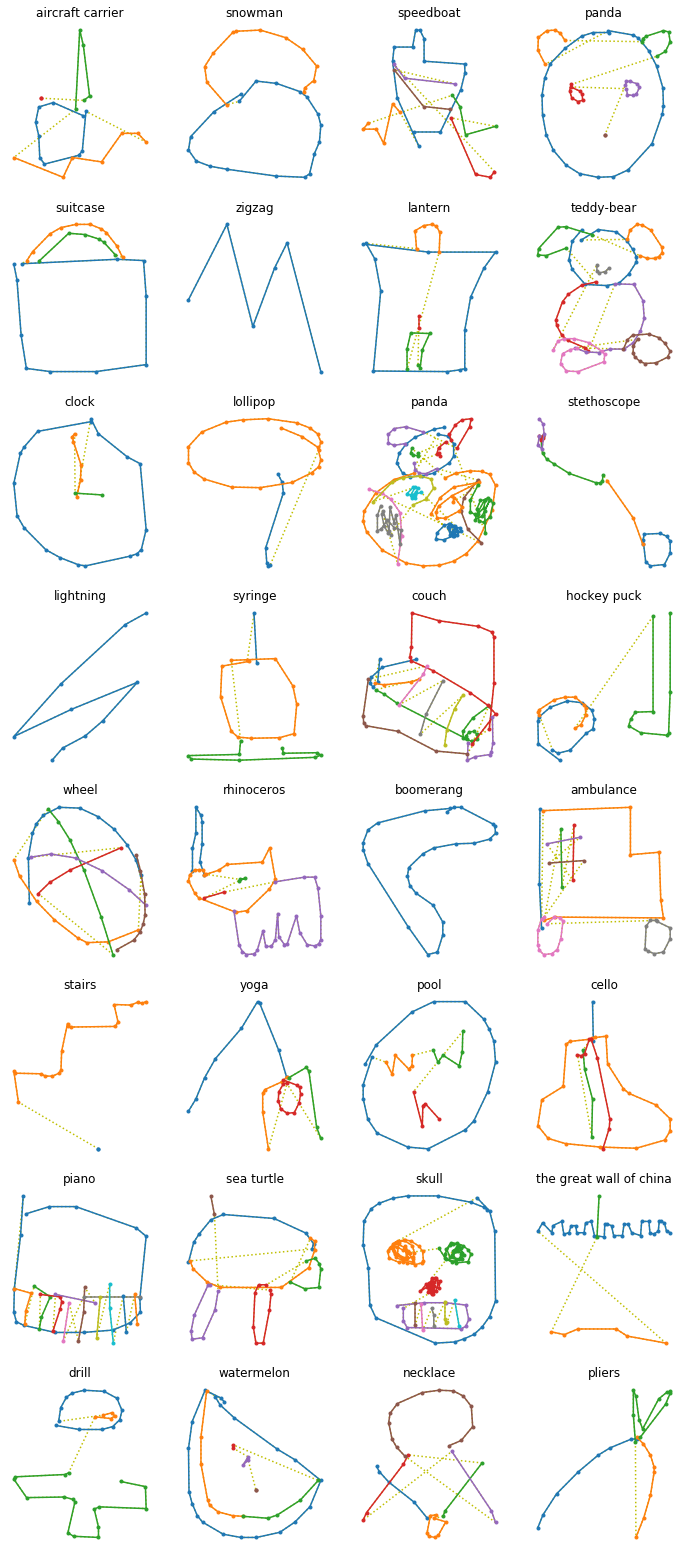

In [13]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

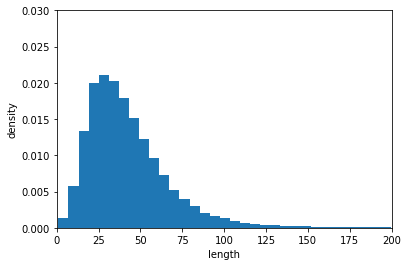

In [14]:
# Let's visualize density of points per sketch:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [15]:
# Prepare sketches for training. Crop long sketches (with more than 100 points):
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [16]:
# ... and train a model on trimmed sketches

SketchRNNModel = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=1e-2, clipnorm=1.)
SketchRNNModel.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
SketchRNNHistory = SketchRNNModel.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)



Epoch 1/2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
      6/Unknown - 5s 814ms/step - loss: 5.8389 - accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0198

InvalidArgumentError:  [_Derived_]  Operation expected a list with 10 elements but got a list with 9 elements.
	 [[{{node gradients/TensorArrayUnstack/TensorListFromTensor_grad/TensorListStack}}]]
	 [[SGD/gradients/sequential/lstm_1/StatefulPartitionedCall_grad/StatefulPartitionedCall]] [Op:__inference_keras_scratch_graph_8843]

Function call stack:
keras_scratch_graph -> keras_scratch_graph -> keras_scratch_graph


In [ ]:
# .. evaluate:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = SketchRNNModel.predict(test_set)

In [ ]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))